#### Dependencies:

In [1]:
from KM_prediction import *
import os
CURRENT_DIR = os.getcwd()

Before using KM prediction for the first time, we have to download the ESM-1b model:

In [2]:
model, alphabet = torch.hub.load("facebookresearch/esm:v0.4.0", "esm1b_t33_650M_UR50S")

Using cache found in C:\Users\marle/.cache\torch\hub\facebookresearch_esm_v0.4.0


Example for calculating KM prediction. You can enter multiple enyzmes and substrates. Enzyme 1 will be paired with substrate 1, enzyme 2 will be paired with substrate 2 and so on...

Enter enzymes as amino acid sequences and substrate either as SMILES strings, KEGG Compound IDs, or InChI strings.

In [3]:
import pandas as pd

split = "full"

data = pd.read_pickle(join("../data", "splits", split, "val_data.pkl"))

data['substrate_IDs'] = data['substrate_IDs'].apply(list)

data['substrate_IDs'] = ['#'.join(map(str, l)) for l in data['substrate_IDs']]

data['product_IDs'] = data['product_IDs'].apply(list)

data['product_IDs'] = ['#'.join(map(str, l)) for l in data['product_IDs']]

KMvalid, KMinvalid = KM_predicton(substrate_list = data["Main Substrate"].tolist(), 
             enzyme_list = data["Sequence"].tolist(),
                                 KM = np.log10(data["Km"].tolist()),
                                 EC = data["ECs"].tolist())

Step 1/3: Calculating numerical representations for all metabolites.
.....1(a) Calculating input matrices for Graph Neural Network
.....1(b) Calculating numerical metabolite representations using a Graph Neural Network
Step 2/3: Calculating numerical representations for all enzymes.
.....2(a) Loading ESM-1b model.
.....2(b) Calculating enzyme representations.
Step 3/3: Making predictions for KM.


In [4]:
# KMvalid.to_pickle('../data/output_' + organism + '.pkl')
df = KMvalid

In [9]:
import scipy as sci
import sklearn.metrics as sk

rms = sk.mean_squared_error(df["value"].tolist(), df["KM [mM]"].tolist(), squared=False)
R2 = sk.r2_score(df["value"].tolist(), df["KM [mM]"].tolist())
Pearson = sci.stats.pearsonr(df["value"].tolist(), df["KM [mM]"].tolist())[0]

print(rms, R2, Pearson)

rms = sk.mean_squared_error((10**df["value"]).tolist(), ((10**df["KM [mM]"])/1000).tolist(), squared=False)
R2 = sk.r2_score((10**df["value"]).tolist(), ((10**df["KM [mM]"])/1000).tolist())
Pearson = sci.stats.pearsonr((10**df["value"]).tolist(), ((10**df["KM [mM]"])/1000).tolist())[0]
MAE = np.mean(abs(np.array((10**df["value"]).tolist()) - np.array(((10**df["KM [mM]"])/1000).tolist())))
MedAE = np.median(abs(np.array((10**df["value"]).tolist()) - np.array(((10**df["KM [mM]"])/1000).tolist())))

print(rms, R2, Pearson, MAE, MedAE)

2.9891739936216535 -13.19129295249482 0.5691185107453821
0.0019392709743795602 0.029436287101281988 0.314296242197024 0.0008028516654652407 0.0001407402507233201


In [1]:
import numpy as np
from os.path import join
np.save(join("..", "data", "secondary", "y_test_true_xgboost_baseline.npy"), np.array([-1.170576, -1.333023, -1.185020, -1.209680, -1.281105, -1.290721, -1.172339, -2.033401, -2.086075, -0.291156, 0.019615, -1.053020, -0.030628, 0.185625, 0.108214, -0.925141, -0.734253, -1.415040, -0.678926, -0.044681, -0.818516]))

In [ ]:
df = df.rename(columns={'enzyme': 'Sequence'})       
data_train = pd.read_pickle(open("../data/train-test data/training_data.pkl", "rb"))

In [ ]:
df["reaction_sim"] = np.nan

for ind in df.index:
    max_sim=[]
    for ind2 in data_train.index:
        vector1_norm = df["GNN rep"][ind] / np.linalg.norm(df["GNN rep"][ind])
        vector2_norm = data_train["GNN FP"][ind2] / np.linalg.norm(data_train["GNN FP"][ind2])
        sim = 1- scipy.spatial.distance.cdist(vector1_norm.reshape(1,-1),vector2_norm.reshape(1,-1), metric='cosine')
        max_sim.append(sim)
        print(sim)
    df["reaction_sim"][ind] = max(max_sim)
    

df["reaction_sim"]= (df["reaction_sim"] - np.min(df["reaction_sim"]))
df["reaction_sim"] = df["reaction_sim"]/np.max(df["reaction_sim"])

df["reaction_sim"] = df["reaction_sim"]*100

92


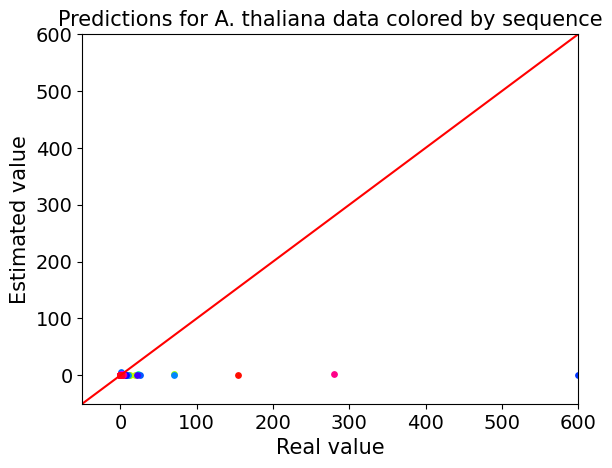

In [22]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

uniq = list(set(df['enzyme']))
z = range(1, len(uniq))
hot = plt.get_cmap('hsv')
cNorm = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

for i in range(len(uniq)):
    indx = df['enzyme'] == uniq[i]
    plt.scatter(df["value"][indx], df["KM [mM]"][indx], s=15, color=scalarMap.to_rgba(i), label=uniq[i])
    
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Real value (log)', fontsize=15)
plt.ylabel('Estimated value (log)', fontsize=15)
plt.title('Predictions for A. thaliana data colored by sequence', fontsize=15)
plt.axline((1, 1), slope=1, c='red')
plt.show()

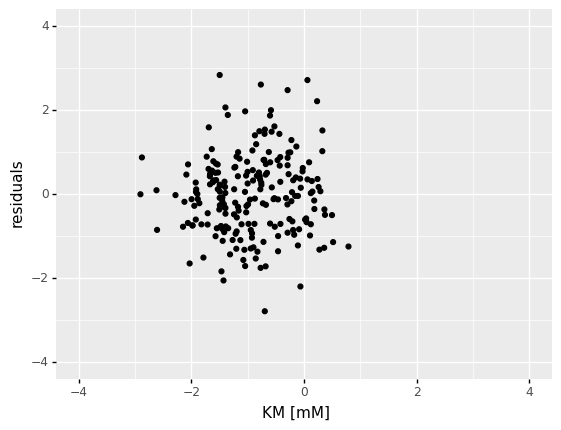

<ggplot: (-9223371943974452612)>

In [23]:
import plotnine 

df["residuals"] = df["value"] - df["KM [mM]"]
    
(plotnine.ggplot(df, plotnine.aes(x = "KM [mM]", y ="residuals")) +
plotnine.geom_point()+
plotnine.xlim(-4,4)+
plotnine.ylim(-4,4))

In [ ]:
sci.stats.probplot(np.subtract(np.array(df["value"].tolist()), np.array(df["KM [mM]"].tolist())), dist="norm", plot=plt)
plt.show()

In [ ]:
# for ind in df.index:
#     try:
#         EC = int(df["EC"][ind][0][0])
#         EC_KM[EC-1].append(df["value"][ind])
#         EC_KM_pred[EC-1].append(df["KM [mM]"][ind])
#     except IndexError:
#         pass

In [ ]:
# fig, ax = plt.subplots(figsize= (8,8))
# plt.rcParams.update({'font.size': 28})

# classes = [str(i) for i in range(1,7)]

# for i in range(len(EC_kcat)):
    
#     circle = plt.Circle((np.mean(EC_kcat[i]), np.mean(EC_kcat_pred[i]) ),
#                         np.sqrt(len(EC_kcat_pred[i]))/300, color='navy', fill = True)
#     ax.add_artist(circle)
#     if i ==5:
#         ax.annotate("EC"+ str(i+1), (np.mean(EC_kcat[i])+0.01, np.mean(EC_kcat_pred[i])-0.05), fontsize=17, c='red', weight = "bold")
#     else:
#         ax.annotate("EC"+ str(i+1), (np.mean(EC_kcat[i])+0.03, np.mean(EC_kcat_pred[i])-0.01), fontsize=17, c='red', weight = "bold")
    

# ticks2 = [0.2, 0.6,1,1.4,1.8]
# labs = ticks2
# ax.set_xticks(ticks2)
# ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
# ax.tick_params(axis='x', length=0, rotation = 0)

# ax.set_yticks(ticks2)
# ax.set_yticklabels(labs,  y= -0.03, fontsize=26)
# ax.tick_params(axis='y', length=0, rotation = 0)

# plt.ylim((0,2))
# plt.xlim((0, 2))
# plt.legend(loc = "upper left", fontsize=20)
# plt.xlabel('mean measured \n $k_{cat}$ value on $\log_{10}$-scale')
# plt.ylabel('mean predicted \n $k_{cat}$ value on $\log_{10}$-scale')
# ax.yaxis.set_label_coords(-0.15, 0.5)
# ax.xaxis.set_label_coords(0.5,-0.13)

# plt.plot([0,2], [0,2], color='grey', alpha = 0.3, linestyle='dashed')
# plt.savefig(join("..", "data", "EC_classes_mean_kcat.png"))
# plt.show()

In [ ]:
df["global_sim"] = (df["seq_sim"]/100)*df["reaction_sim"]

In [ ]:
help_df = df

sim_bins_lb = [0.0, 0.4, 0.8]
sim_bins_ub = [0.4, 0.8, 1]
r2_scores, n_points, pearson_r = [], [], []
for i in range(len(sim_bins_lb)):
    help_df2 = help_df.loc[help_df["global_sim"] <= sim_bins_ub[i]].loc[help_df["global_sim"] >= sim_bins_lb[i]]
    pred = np.array(help_df2["kcat [s^(-1)]"])
    true = np.array(help_df2["value"])
    r2_scores.append(sk.r2_score(true, pred))
    pearson_r.append(sci.stats.pearsonr(true, pred)[0])
    mse = np.mean(abs(true - pred)**2)
    n_points.append(len(pred))
    print("%s - %s" % (sim_bins_lb[i], sim_bins_ub[i]), r2_scores[-1], pearson_r[-1], mse, len(pred))
    

plt.rcParams.update({'font.size': 28})

fig, ax = plt.subplots(figsize= (8,6))

for i in range(len(sim_bins_lb)):    
    plt.scatter(i, r2_scores[i], c='navy', marker="o", linewidths= 8)
    ax.annotate(n_points[i], (i-0.06, r2_scores[i]+0.03), fontsize=17, c= "black", weight = "bold")

    
plt.xlabel('Global imilarity score')
plt.ylabel('Coefficient of \n determination R²')
ax.yaxis.set_label_coords(-0.13, 0.5)
ax.xaxis.set_label_coords(0.5,-0.23)

ticks2 = np.array(range(len(sim_bins_lb)))
labs = ["%s - %s" % (sim_bins_lb[i], sim_bins_ub[i]) for i in range(len(sim_bins_lb))]
ax.set_xticks(ticks2)
ax.set_xticklabels(labs,  y= -0.03, fontsize=24)
ax.tick_params(axis='x', length=0, rotation = 0)

plt.ylim((-1,1))
plt.show()

In [ ]:
df.to_pickle('../data/final_output_' + organism + '.pkl')